# General Election Poll Analysis

In the spirit of the election season, I will be analyzing US presidential election polling data from 2016 and 2020.  I will be answering many questions, including who might win in 2020.  

This notebook will be updated until the conclusion of the 2020 election.

## Importing and Cleaning the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as r
from datetime import datetime
from scipy import stats

Three unique datasets will be utilized in this analysis:

* 2016 polling data (from Kaggle)
* 2020 polling data (from FiveThirtyEight)
* 2016 Election Results by State and County (from Data World)

### 2016 Polling Data (Trump vs. Clinton)

In [2]:
data_2016 = pd.read_csv("../input/2016-election-polls/presidential_polls.csv")
data_2016 = data_2016[["startdate", "enddate", "state", "pollster", "grade", "samplesize", "population", "adjpoll_clinton", "adjpoll_trump"]]
trump_clinton = data_2016.rename(columns = {"startdate": "start_date", "enddate": "end_date", "grade":"fte_grade", "samplesize":"sample_size", "adjpoll_clinton":"Clinton", "adjpoll_trump":"Trump"})
trump_clinton["start_date"] = pd.to_datetime(trump_clinton["start_date"])
trump_clinton["end_date"] = pd.to_datetime(trump_clinton["end_date"])
trump_clinton = trump_clinton.sort_values(by = ["end_date", "start_date"]) #Arranging the polls from most to least recent
trump_clinton["dem_lead"] = trump_clinton["Clinton"] - trump_clinton["Trump"] #lead of the democratic candidate (negative if they are losing)

In [3]:
trump_clinton.head()

,start_date,end_date,state,pollster,fte_grade,sample_size,population,Clinton,Trump,dem_lead
3077,2015-11-07,2015-11-08,South Carolina,Public Policy Polling,B+,1290.0,v,40.63694,45.19826,-4.56132
6520,2015-11-07,2015-11-08,South Carolina,Public Policy Polling,B+,1290.0,v,40.48820,45.19637,-4.70817
9901,2015-11-07,2015-11-08,South Carolina,Public Policy Polling,B+,1290.0,v,40.69941,45.18212,-4.48271
3206,2015-11-09,2015-11-13,Virginia,Roanoke College,C+,555.0,rv,49.81532,36.21050,13.60482
6638,2015-11-09,2015-11-13,Virginia,Roanoke College,C+,555.0,rv,49.00173,37.02524,11.97649


After renaming some columns, this data is already in the format we want.  Only the important columns are extracted.

In [4]:
trump_clinton.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10236 entries, 3077 to 6833
Data columns (total 10 columns):
start_date     10236 non-null datetime64[ns]
end_date       10236 non-null datetime64[ns]
state          10236 non-null object
pollster       10236 non-null object
fte_grade      9102 non-null object
sample_size    10233 non-null float64
population     10236 non-null object
Clinton        10236 non-null float64
Trump          10236 non-null float64
dem_lead       10236 non-null float64
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 879.7+ KB


The missing values in the "grade" column represent polls with an unknown accuracy.

### 2020 Polling Data

In [5]:
data_2020 = pd.read_csv("../input/2020-general-election-polls/president_polls.csv")
data_2020 = data_2020[["poll_id","start_date", "end_date", "state", "pollster", "fte_grade", "sample_size", "population", "answer", "pct"]]

In [6]:
data_2020.head()

,poll_id,start_date,end_date,state,pollster,fte_grade,sample_size,population,answer,pct
0,63277,1/9/20,1/12/20,Michigan,EPIC-MRA,B+,600,lv,Biden,50.0
1,63277,1/9/20,1/12/20,Michigan,EPIC-MRA,B+,600,lv,Trump,44.0
2,63277,1/9/20,1/12/20,Michigan,EPIC-MRA,B+,600,lv,Sanders,50.0
3,63277,1/9/20,1/12/20,Michigan,EPIC-MRA,B+,600,lv,Trump,45.0
4,63277,1/9/20,1/12/20,Michigan,EPIC-MRA,B+,600,lv,Warren,48.0


In [7]:
data_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735 entries, 0 to 2734
Data columns (total 10 columns):
poll_id        2735 non-null int64
start_date     2735 non-null object
end_date       2735 non-null object
state          1435 non-null object
pollster       2735 non-null object
fte_grade      2583 non-null object
sample_size    2735 non-null int64
population     2735 non-null object
answer         2735 non-null object
pct            2735 non-null float64
dtypes: float64(1), int64(2), object(7)
memory usage: 213.8+ KB


Again, some missing values exist in the "grade" column.  The missing values in the "state" column represent national polls:

In [8]:
data_2020["state"] = data_2020.state.fillna("U.S.")

We will have to clean this data by spreading the candidates into their own separate columns, and will also remove irrelevant candidates.  First, it will be necessary to separate different individual matchups involving Trump into different data tables.

In [9]:
def trump_opponent(data_2020, opp):
    trump_vs = data_2020[(data_2020["answer"] == opp) | (data_2020["answer"] == "Trump")]
    trump_vs = trump_vs.pivot_table(values = "pct", index = ["poll_id", "start_date", "end_date", "state", "pollster", "fte_grade", "sample_size", "population"], columns = "answer")
    trump_vs = trump_vs.dropna(axis = 0, how = "any") #Drops the Trump polls against any opponent that isn't our opp parameter
    trump_vs = trump_vs.reset_index().drop(columns = ["poll_id"])
    trump_vs["start_date"] = pd.to_datetime(trump_vs["start_date"])
    trump_vs["end_date"] = pd.to_datetime(trump_vs["end_date"]) 
    trump_vs["dem_lead"] = trump_vs[opp] - trump_vs["Trump"] 
    trump_vs = trump_vs.sort_values(by = ["end_date", "start_date"]) #Arranging the polls from most to least recent
    return trump_vs

#### Trump vs. Biden

In [10]:
trump_biden = trump_opponent(data_2020, "Biden")

trump_biden.head()

answer,start_date,end_date,state,pollster,fte_grade,sample_size,population,Biden,Trump,dem_lead
0,2018-11-27,2018-11-28,Ohio,Public Policy Polling,B,648,v,48.0,45.250000,2.750000
1,2018-12-16,2018-12-17,U.S.,Harris Insights & Analytics,C+,1001,rv,42.0,36.666667,5.333333
2,2019-01-04,2019-01-07,North Carolina,Public Policy Polling,B,750,rv,49.0,45.333333,3.666667
3,2019-01-19,2019-01-21,U.S.,Public Policy Polling,B,760,rv,53.0,41.666667,11.333333
4,2019-01-24,2019-01-26,Michigan,Glengariff Group Inc.,B/C,600,lv,53.3,41.600000,11.700000


#### Trump vs. Sanders

In [11]:
trump_sanders = trump_opponent(data_2020, "Sanders")

trump_sanders.head()

answer,start_date,end_date,state,pollster,fte_grade,sample_size,population,Sanders,Trump,dem_lead
0,2018-11-27,2018-11-28,Ohio,Public Policy Polling,B,648,v,47.0,45.250000,1.750000
1,2018-12-16,2018-12-17,U.S.,Harris Insights & Analytics,C+,1001,rv,38.0,36.666667,1.333333
2,2019-01-04,2019-01-07,North Carolina,Public Policy Polling,B,750,rv,48.0,45.333333,2.666667
4,2019-01-16,2019-01-21,New Hampshire,Praecones Analytica,B/C,593,rv,54.1,41.033333,13.066667
3,2019-01-19,2019-01-21,U.S.,Public Policy Polling,B,760,rv,51.0,41.666667,9.333333


#### Trump vs. Warren

In [12]:
trump_warren = trump_opponent(data_2020, "Warren")

trump_warren.head()

answer,start_date,end_date,state,pollster,fte_grade,sample_size,population,Trump,Warren,dem_lead
0,2018-11-27,2018-11-28,Ohio,Public Policy Polling,B,648,v,45.250000,43.0,-2.250000
1,2019-01-04,2019-01-07,North Carolina,Public Policy Polling,B,750,rv,45.333333,46.0,0.666667
3,2019-01-16,2019-01-21,New Hampshire,Praecones Analytica,B/C,593,rv,41.033333,53.5,12.466667
2,2019-01-19,2019-01-21,U.S.,Public Policy Polling,B,760,rv,41.666667,48.0,6.333333
4,2019-01-24,2019-01-26,Michigan,Glengariff Group Inc.,B/C,600,lv,41.600000,45.8,4.200000


#### Trump vs. Buttigieg

In [13]:
trump_buttigieg = trump_opponent(data_2020, "Buttigieg")

trump_buttigieg.head()

answer,start_date,end_date,state,pollster,fte_grade,sample_size,population,Buttigieg,Trump,dem_lead
0,2019-03-19,2019-03-20,U.S.,Harris Insights & Analytics,C+,1001,rv,27.0,35.75,-8.75
2,2019-03-27,2019-03-28,U.S.,Public Policy Polling,B,846,rv,45.0,41.00,4.00
1,2019-03-28,2019-03-30,Nevada,Emerson College,A-,719,rv,48.0,51.22,-3.22
3,2019-04-03,2019-04-04,U.S.,Harris Insights & Analytics,C+,1002,rv,28.0,37.00,-9.00
4,2019-04-11,2019-04-14,U.S.,Emerson College,A-,914,rv,48.6,49.55,-0.95


Now, we have 2020 polling data in the exact same format as our 2016 polling data.

### 2016 Election Results

Finally, let's take a look at the results of the 2016 election.  We will get the percentage of Trump and Clinton voters for each state (not including third-party candidates), as well as manually add a row displaying the national results.

In [14]:
results_2016 = pd.read_csv("../input/2020-general-election-polls/nytimes_presidential_elections_2016_results_county.csv")
results_2016 = results_2016.groupby("State").sum()[["Clinton", "Trump"]]
results_2016.loc["U.S."] = [65853514, 62984828] #Adding a row for the national result
results_2016["Clinton_pct"] = 100 * results_2016["Clinton"] / (results_2016["Clinton"] + results_2016["Trump"])
results_2016["Trump_pct"] = 100 * results_2016["Trump"] / (results_2016["Clinton"] + results_2016["Trump"]) #percentages
results_2016["dem_lead"] = results_2016["Clinton_pct"] - results_2016["Trump_pct"]
results_2016["index"] = list(range(0,50))
results_2016["state"] = results_2016.index
results_2016 = results_2016.set_index("index")

In [15]:
results_2016.head()

,Clinton,Trump,Clinton_pct,Trump_pct,dem_lead,state
index,,,,,,
0,718084.0,1306925.0,35.460781,64.539219,-29.078439,Alabama
1,888374.0,972900.0,47.729351,52.270649,-4.541298,Arizona
2,378729.0,677904.0,35.843003,64.156997,-28.313994,Arkansas
3,5488776.0,2970470.0,64.884932,35.115068,29.769864,California
4,1208095.0,1136354.0,51.530018,48.469982,3.060037,Colorado


In [16]:
results_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 6 columns):
Clinton        50 non-null float64
Trump          50 non-null float64
Clinton_pct    50 non-null float64
Trump_pct      50 non-null float64
dem_lead       50 non-null float64
state          50 non-null object
dtypes: float64(5), object(1)
memory usage: 2.7+ KB


Note that there may be slight inaccuracies in comparison to the actual results because we do not have data for independant candidates.  Therefore, the Trump and Clinton percentages add up to 100% which is slightly misleading.

## What Happened in 2016? (The Polling Averages)

This section will analyze both national and battleground state polls in 2016 by comparing them to the actual results to determine how we should treat the 2020 polls this far into the election cycle.  We will compare the averages of all polls, historically reliable polls only, and polls of likely voters for each state.

In [17]:
def trump_vs_clinton(trump_clinton, state, results_2016, reliable = False, likely_voters = False):
    
    #getting polls for the specified state / U.S. and filtering if necessary
    match_up = trump_clinton
    match_up = match_up[match_up["state"] == state]
    
    if reliable == True:
        match_up = match_up[match_up["fte_grade"].isin(["A+", "A", "A-"])]
    if likely_voters == True:
        match_up = match_up[match_up["population"] == "lv"]
    
    #Accounting for repeated polls which have the same end date
    
    match_up = match_up.groupby(["end_date", "pollster", "fte_grade", "population"]).mean().reset_index()
    match_up.index = match_up["end_date"]
    
    #A rolling average of democrat lead/deficit in the past 14 days
    
    if state == "U.S.":
        match_up["average_lead"] = match_up["dem_lead"].rolling("14D", min_periods = 0).mean()
    else:
        match_up["average_lead"] = match_up["dem_lead"].rolling("30D", min_periods = 0).mean()
    
    #Plotting the time series
    
    polls_vs_final =  [match_up.iloc[-1]["average_lead"], results_2016[results_2016["state"] == state].iloc[0]["dem_lead"]]
    polls_df = pd.DataFrame(polls_vs_final)
    polls_df[1] = ["Final/Current Polling Average", "Actual Results"]
    
    plt.subplots(figsize = (9,6))
    plt.subplot(1,2,1)
    plt.plot(match_up["end_date"], match_up["average_lead"])
    plt.xlabel("Date")
    plt.xticks(rotation = 90)
    plt.ylabel("Lead or Deficit vs. Trump (%)")
    plt.title(f"Trump vs. Clinton in {state}")  
    plt.subplot(1,2,2)
    plt.bar(polls_df[1], polls_df[0])
    plt.xticks(rotation = 90)
    plt.title("Poll Accuracy Chart")
    plt.show()
    
    if reliable == True:
        return f"Percentage Points of Trump Underestimation in {state} From Historically Reliable Polls: {round(polls_vs_final[0] - polls_vs_final[1], 2)}%"
    if likely_voters == True:
        return f"Percentage Points of Trump Underestimation in {state} From Polls of Likely Voters: {round(polls_vs_final[0] - polls_vs_final[1], 2)}%"
    return f"Percentage Points of Trump Underestimation in {state} From All Polls: {round(polls_vs_final[0] - polls_vs_final[1], 2)}%"

### Nationally

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


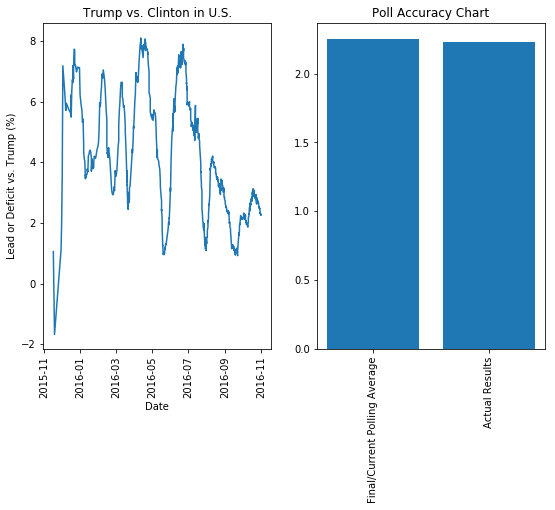

'Percentage Points of Trump Underestimation in U.S. From All Polls: 0.03%'

In [18]:
trump_vs_clinton(trump_clinton, "U.S.", results_2016)

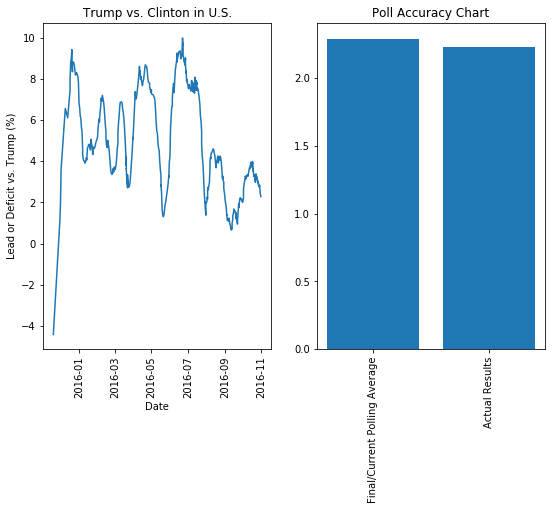

'Percentage Points of Trump Underestimation in U.S. From Historically Reliable Polls: 0.06%'

In [19]:
trump_vs_clinton(trump_clinton, "U.S.", results_2016, reliable = True)

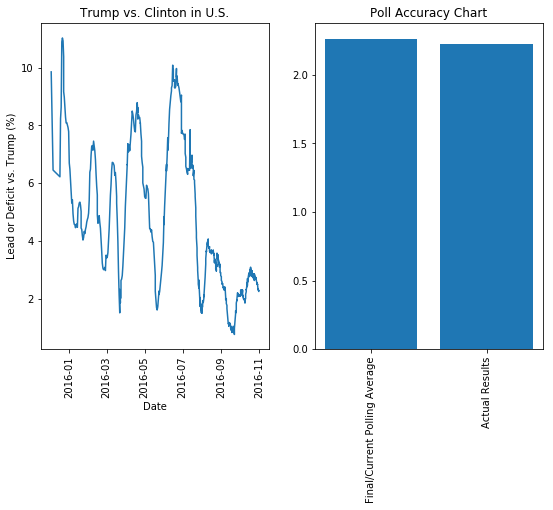

'Percentage Points of Trump Underestimation in U.S. From Polls of Likely Voters: 0.04%'

In [20]:
trump_vs_clinton(trump_clinton, "U.S.", results_2016, likely_voters = True)

In 2016, the national polling was right on the money, as the average of all polls the last two weeks before election day only underestimated Trump's chances by 0.03%.  We can also see that the time of the election was the time of one of Clinton's weakest leads at just over 2%.  

Of course, the US presidential election is decided by the electoral college, not the national popular vote, so it would be helpful to look at battleground states (states that may go either way and decide the election) and other states where Trump performed better than expected.

### Florida

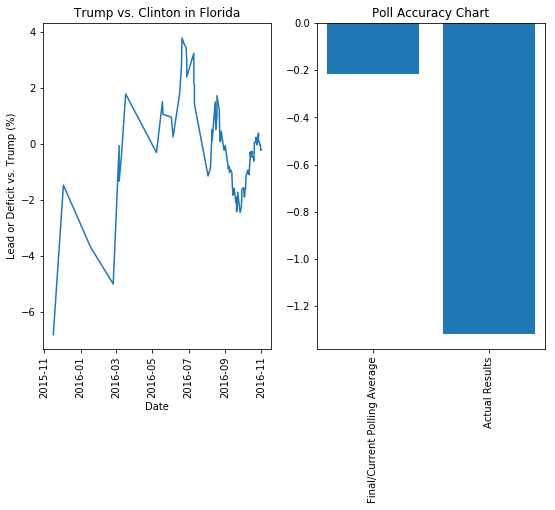

'Percentage Points of Trump Underestimation in Florida From All Polls: 1.1%'

In [21]:
trump_vs_clinton(trump_clinton, "Florida", results_2016)

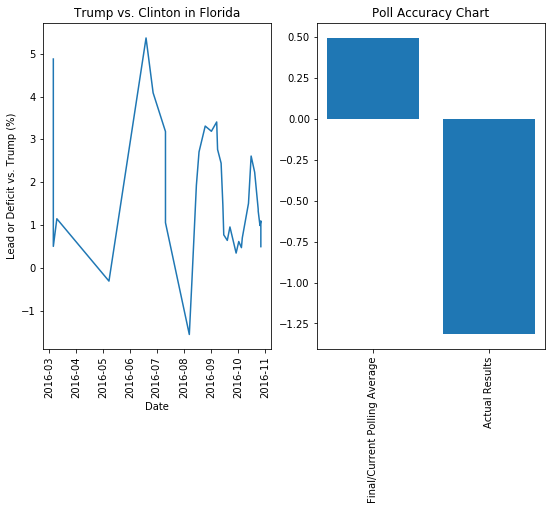

'Percentage Points of Trump Underestimation in Florida From Historically Reliable Polls: 1.81%'

In [22]:
trump_vs_clinton(trump_clinton, "Florida", results_2016, reliable = True)

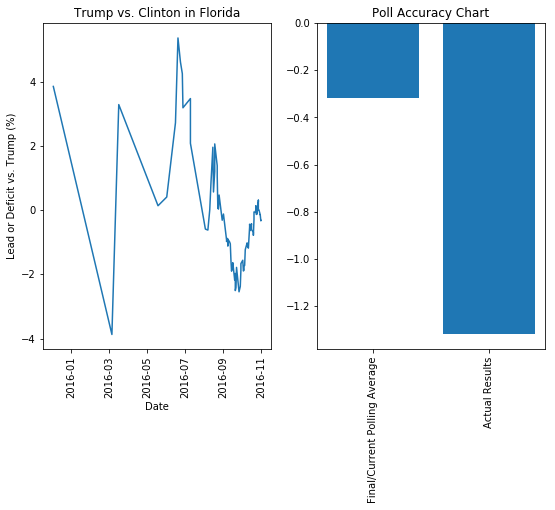

'Percentage Points of Trump Underestimation in Florida From Polls of Likely Voters: 1.0%'

In [23]:
trump_vs_clinton(trump_clinton, "Florida", results_2016, likely_voters = True)

The polling averages only barely underestimated Trump's chances in Florida, with historically reliable polls being least accurate by a slight margin and polls of likely voters being the most accurate.  Only the historically reliable polls had Clinton winning Florida, though we can see her numbers went down quickly in those polls right before the election.

### Pennsylvania

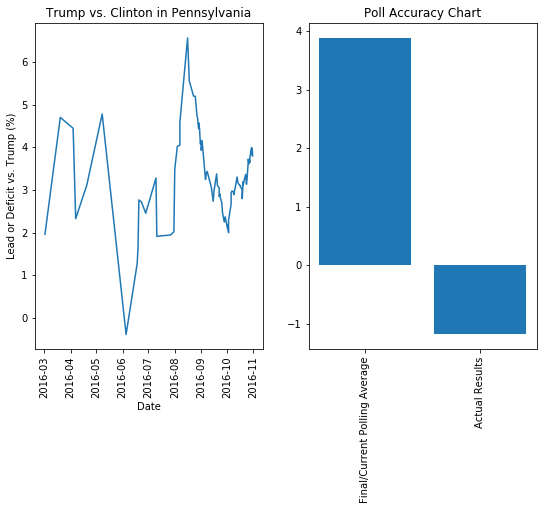

'Percentage Points of Trump Underestimation in Pennsylvania From All Polls: 5.07%'

In [24]:
trump_vs_clinton(trump_clinton, "Pennsylvania", results_2016)

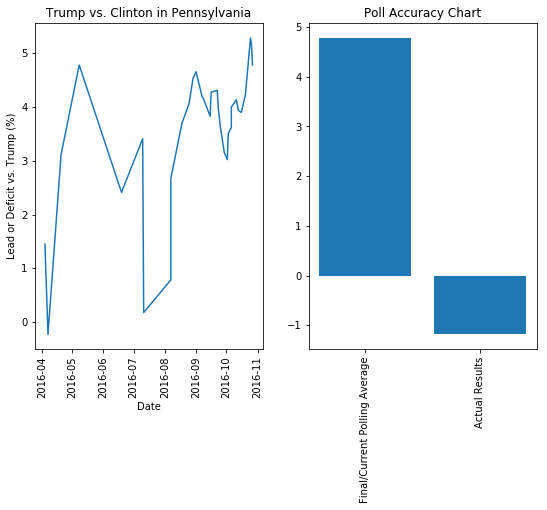

'Percentage Points of Trump Underestimation in Pennsylvania From Historically Reliable Polls: 5.97%'

In [25]:
trump_vs_clinton(trump_clinton, "Pennsylvania", results_2016, reliable = True)

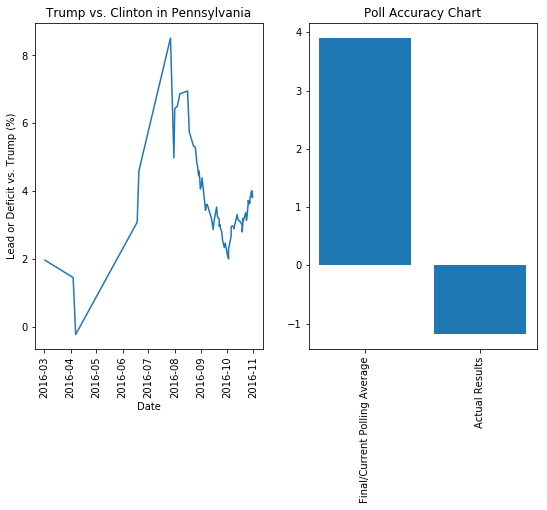

'Percentage Points of Trump Underestimation in Pennsylvania From Polls of Likely Voters: 5.09%'

In [26]:
trump_vs_clinton(trump_clinton, "Pennsylvania", results_2016, likely_voters = True)

Trump's chances in Pennsylvania were underestimated by huge margins, especially by historically reliable polls, despite Clinton having mostly positive momentum towards the end.

### Ohio

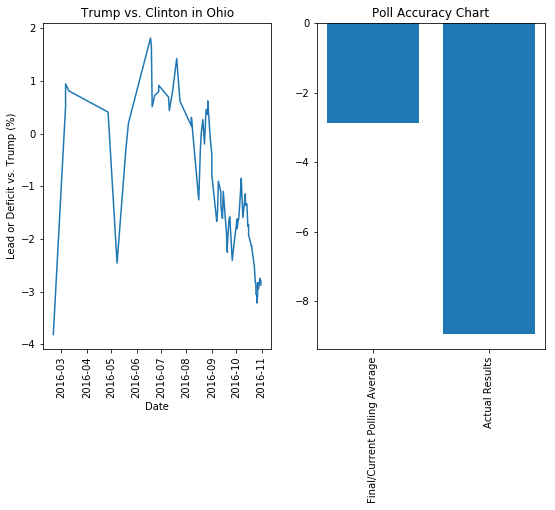

'Percentage Points of Trump Underestimation in Ohio From All Polls: 6.07%'

In [27]:
trump_vs_clinton(trump_clinton, "Ohio", results_2016)

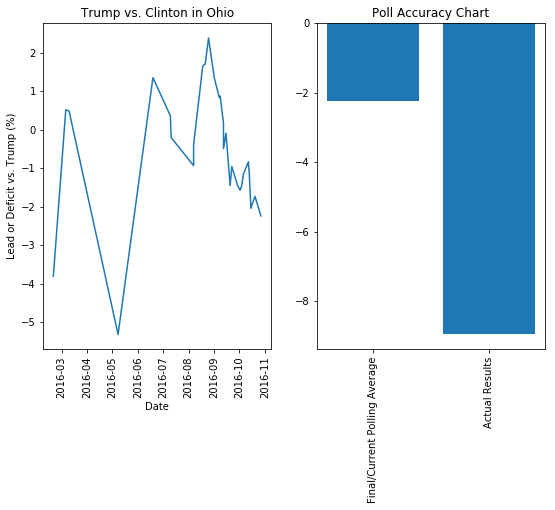

'Percentage Points of Trump Underestimation in Ohio From Historically Reliable Polls: 6.7%'

In [28]:
trump_vs_clinton(trump_clinton, "Ohio", results_2016, reliable = True)

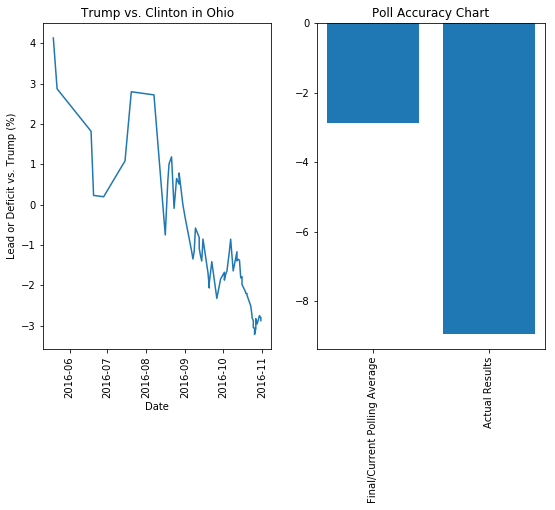

'Percentage Points of Trump Underestimation in Ohio From Polls of Likely Voters: 6.07%'

In [29]:
trump_vs_clinton(trump_clinton, "Ohio", results_2016, likely_voters = True)

Trump was already projected to win Ohio by a small margin, but he ended up winning by over 8%! Again, the historically reliable polls did the worst job of predictions.  We can see, however, that Clinton had a lot of negative momentum towards the end of the Ohio polling.

### Michigan

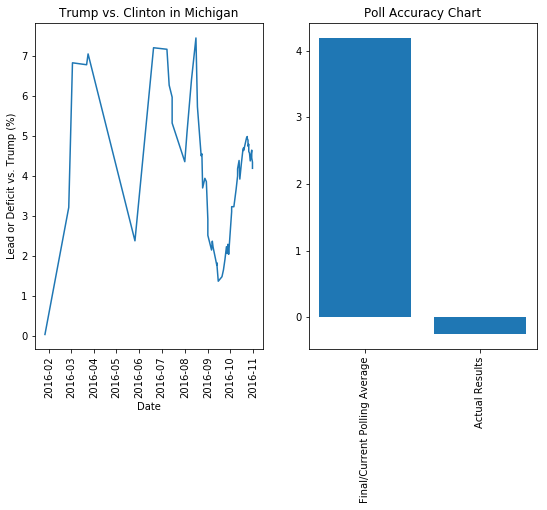

'Percentage Points of Trump Underestimation in Michigan From All Polls: 4.45%'

In [30]:
trump_vs_clinton(trump_clinton, "Michigan", results_2016)

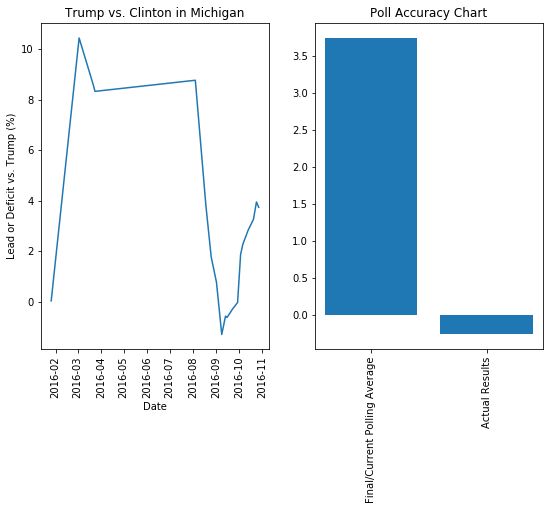

'Percentage Points of Trump Underestimation in Michigan From Historically Reliable Polls: 4.0%'

In [31]:
trump_vs_clinton(trump_clinton, "Michigan", results_2016, reliable = True)

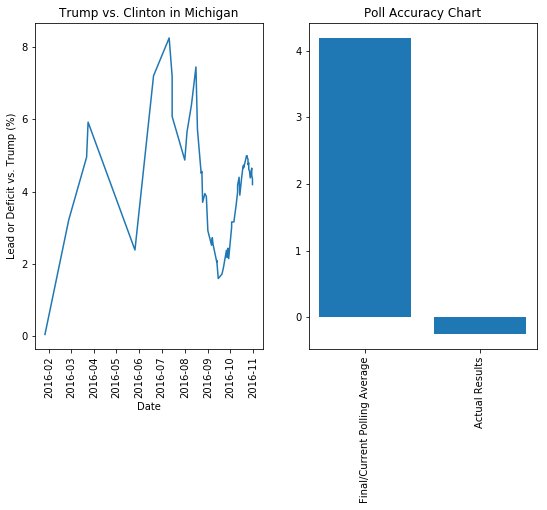

'Percentage Points of Trump Underestimation in Michigan From Polls of Likely Voters: 4.45%'

In [32]:
trump_vs_clinton(trump_clinton, "Michigan", results_2016, likely_voters = True)

Michigan is yet another state that polls failed to predict accurately, though the historically reliable polls did a better job here than the averages of all polls.

### Wisconsin

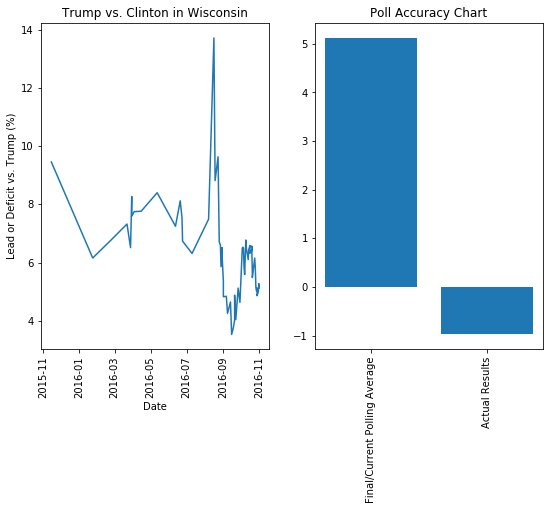

'Percentage Points of Trump Underestimation in Wisconsin From All Polls: 6.1%'

In [33]:
trump_vs_clinton(trump_clinton, "Wisconsin", results_2016)

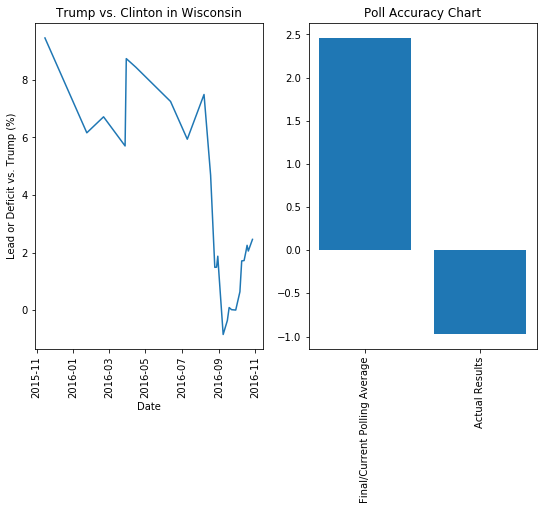

'Percentage Points of Trump Underestimation in Wisconsin From Historically Reliable Polls: 3.44%'

In [34]:
trump_vs_clinton(trump_clinton, "Wisconsin", results_2016, reliable = True)

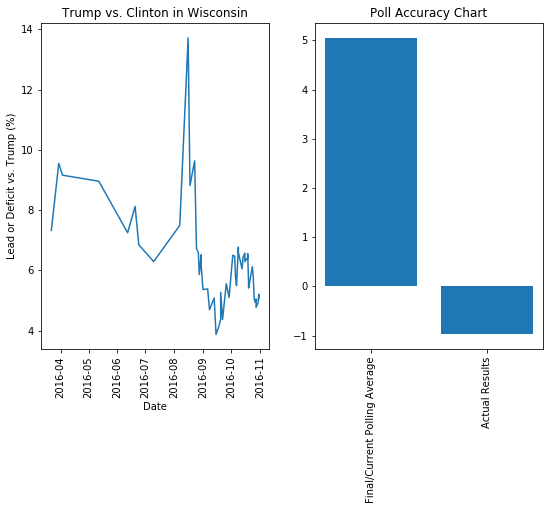

'Percentage Points of Trump Underestimation in Wisconsin From Polls of Likely Voters: 6.03%'

In [35]:
trump_vs_clinton(trump_clinton, "Wisconsin", results_2016, likely_voters = True)

Wisconsin was one of the most unexpected states that Trump won, though the historically reliable polls did much better here that the average of all polls.  Interestingly, however, Clinton had positive momentum in the historically reliable polls and negative momentum in polls of likely voters, as well as the average of all polls.

### Minnesota

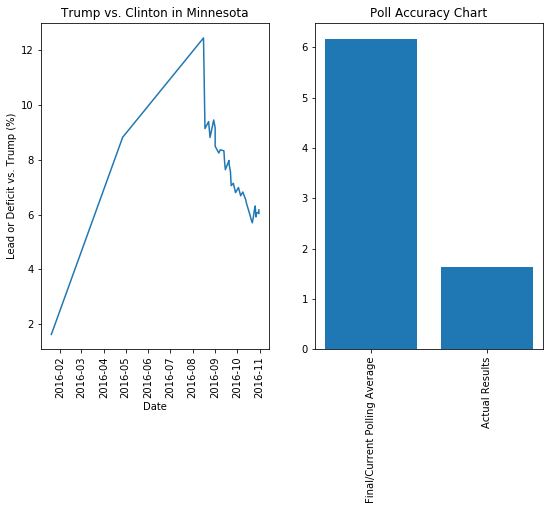

'Percentage Points of Trump Underestimation in Minnesota From All Polls: 4.54%'

In [36]:
trump_vs_clinton(trump_clinton, "Minnesota", results_2016)

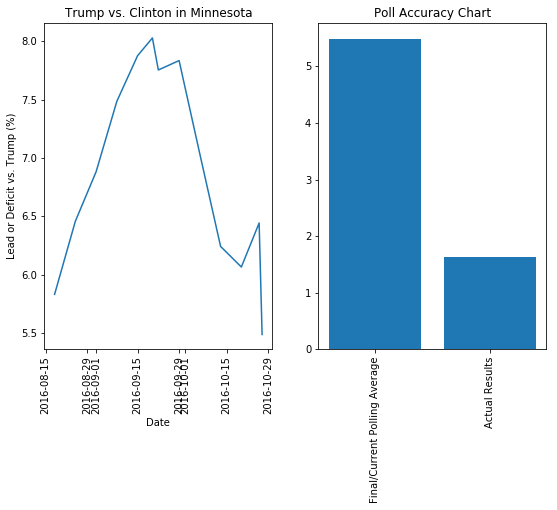

'Percentage Points of Trump Underestimation in Minnesota From Historically Reliable Polls: 3.86%'

In [37]:
trump_vs_clinton(trump_clinton, "Minnesota", results_2016, reliable = True)

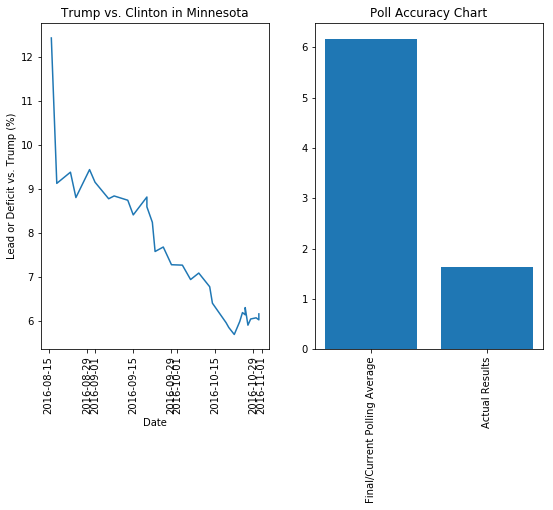

'Percentage Points of Trump Underestimation in Minnesota From Polls of Likely Voters: 4.54%'

In [38]:
trump_vs_clinton(trump_clinton, "Minnesota", results_2016, likely_voters = True)

Clinton did manage to win Minnesota, but by much closer margins than expected.  Again, the historically reliable polls did better here and there was negative momentum for Clinton across the board.

Since the national polls estimated the results of the popular vote perfectly, yet polls underestimated Trump's chances in battleground states, there must have been some states which overestimated Trump's chances.  Note that these states don't play a huge factor in the election because they always decisively vote in a certain direction, so **we have a smaller sample size of polls**.  Let's take a look at the polls of the most populated states in the country.

### California

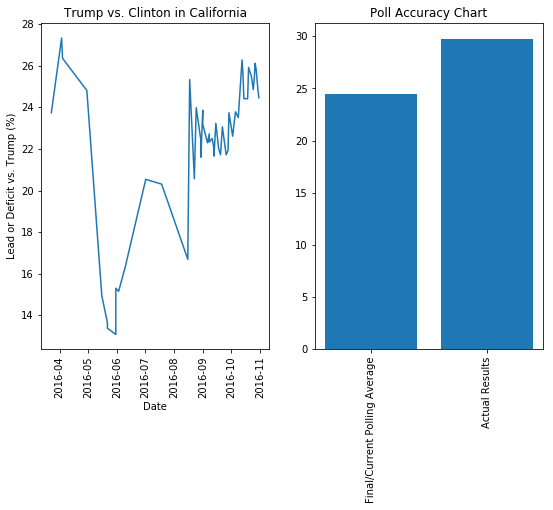

'Percentage Points of Trump Underestimation in California From All Polls: -5.31%'

In [39]:
trump_vs_clinton(trump_clinton, "California", results_2016)

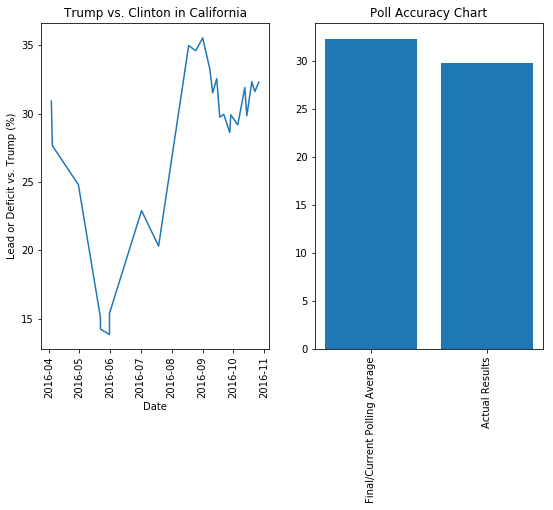

'Percentage Points of Trump Underestimation in California From Historically Reliable Polls: 2.54%'

In [40]:
trump_vs_clinton(trump_clinton, "California", results_2016, reliable = True)

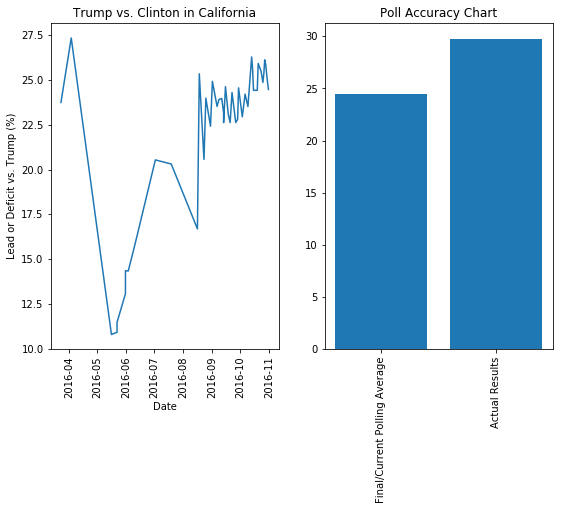

'Percentage Points of Trump Underestimation in California From Polls of Likely Voters: -5.31%'

In [41]:
trump_vs_clinton(trump_clinton, "California", results_2016, likely_voters = True)

Trump's chances were overestimated in this state by the average of all polls, yet interestingly underestimated by historically reliable polls.

### Illinois

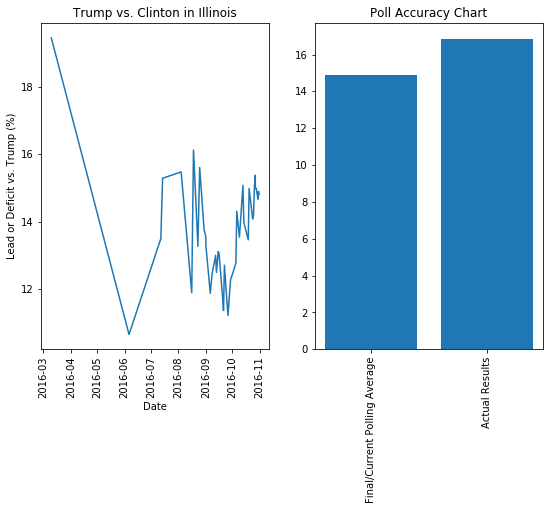

'Percentage Points of Trump Underestimation in Illinois From All Polls: -1.98%'

In [42]:
trump_vs_clinton(trump_clinton, "Illinois", results_2016)

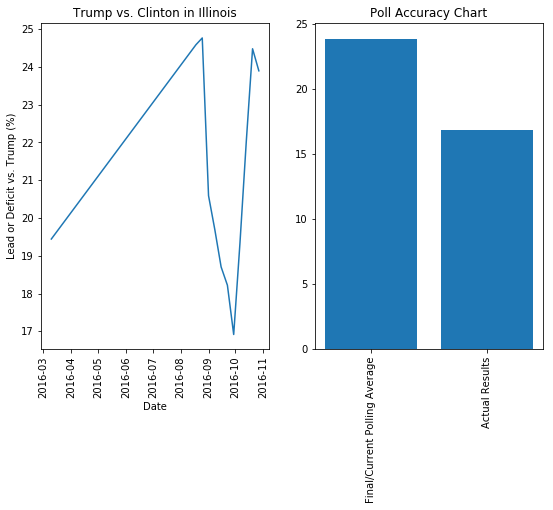

'Percentage Points of Trump Underestimation in Illinois From Historically Reliable Polls: 7.03%'

In [43]:
trump_vs_clinton(trump_clinton, "Illinois", results_2016, reliable = True)

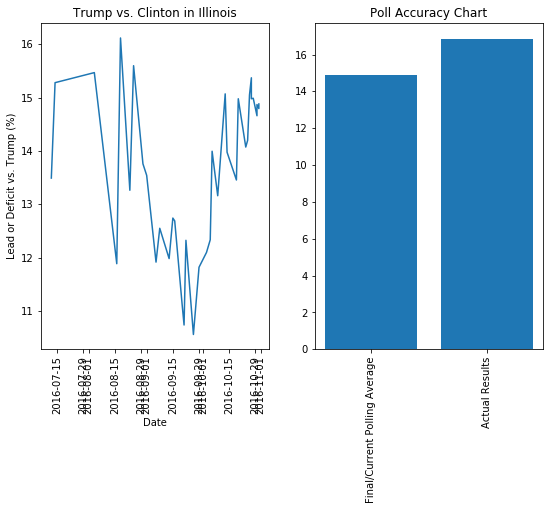

'Percentage Points of Trump Underestimation in Illinois From Polls of Likely Voters: -1.98%'

In [44]:
trump_vs_clinton(trump_clinton, "Illinois", results_2016, likely_voters = True)

Similar patterns exist here as the California polls.  Again, note that the sample size of polls is very small.

### New York

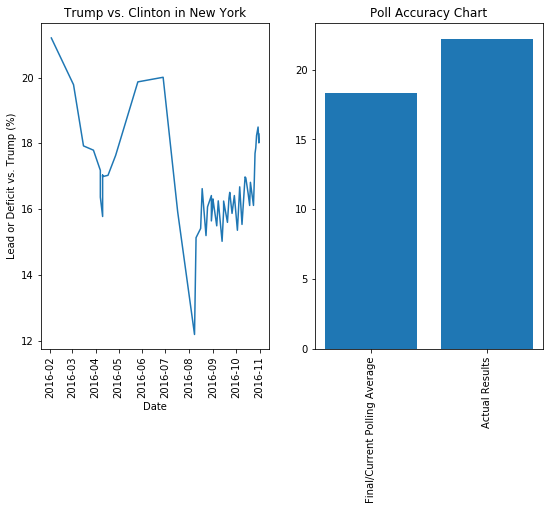

'Percentage Points of Trump Underestimation in New York From All Polls: -3.92%'

In [45]:
trump_vs_clinton(trump_clinton, "New York", results_2016)

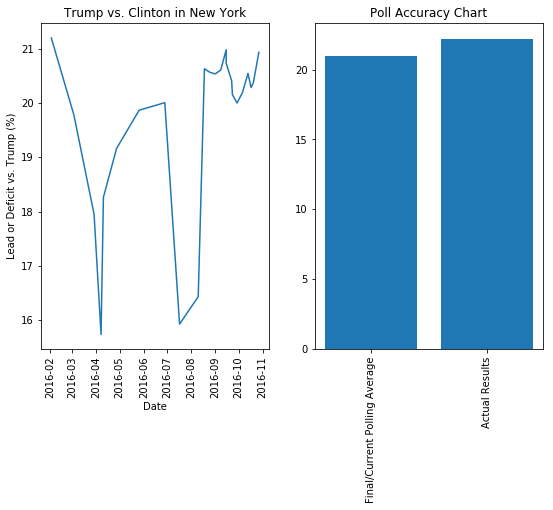

'Percentage Points of Trump Underestimation in New York From Historically Reliable Polls: -1.26%'

In [46]:
trump_vs_clinton(trump_clinton, "New York", results_2016, reliable = True)

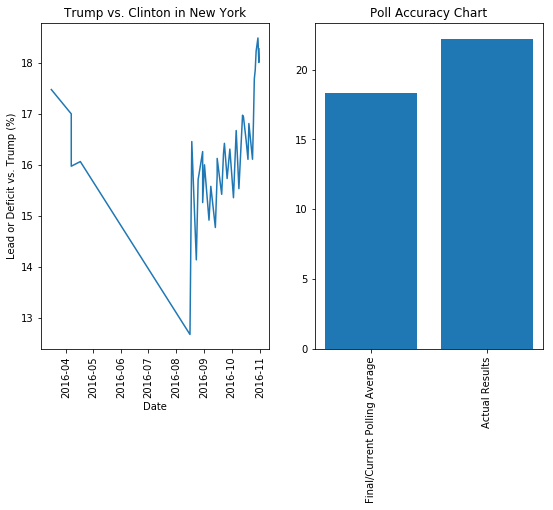

'Percentage Points of Trump Underestimation in New York From Polls of Likely Voters: -3.92%'

In [47]:
trump_vs_clinton(trump_clinton, "New York", results_2016, likely_voters = True)

Trump was overestimated across the board in New York polls.

### Texas

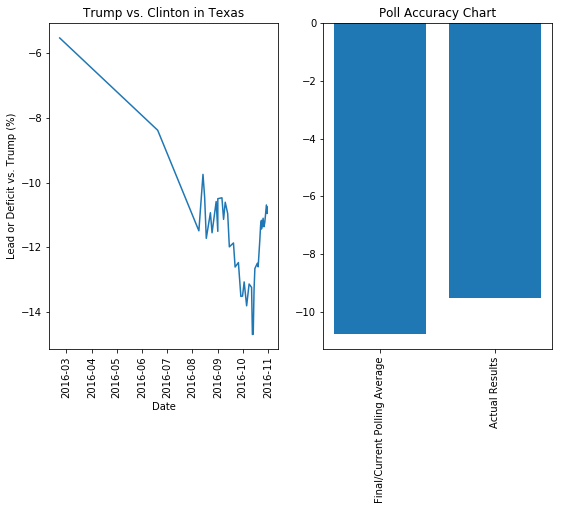

'Percentage Points of Trump Underestimation in Texas From All Polls: -1.24%'

In [48]:
trump_vs_clinton(trump_clinton, "Texas", results_2016)

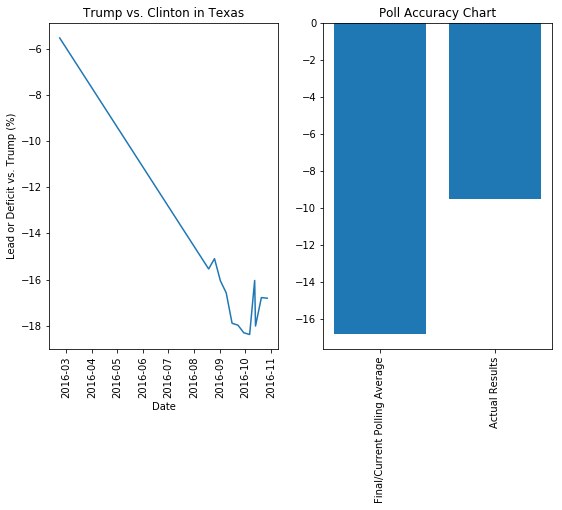

'Percentage Points of Trump Underestimation in Texas From Historically Reliable Polls: -7.29%'

In [49]:
trump_vs_clinton(trump_clinton, "Texas", results_2016, reliable = True)

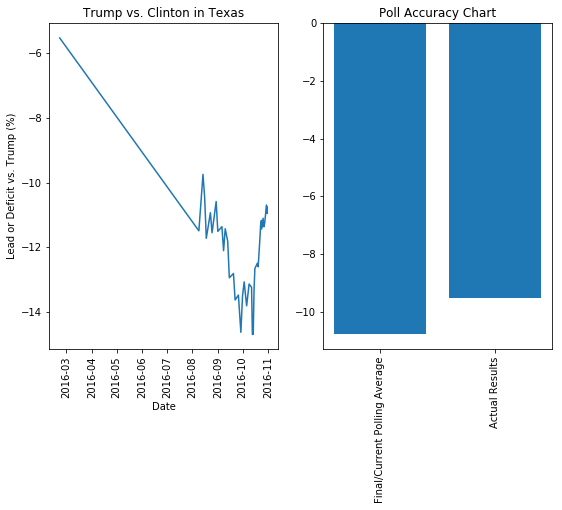

'Percentage Points of Trump Underestimation in Texas From Polls of Likely Voters: -1.24%'

In [50]:
trump_vs_clinton(trump_clinton, "Texas", results_2016, likely_voters = True)

Though Trump carried Texas pretty easily, he was overestimated by 7.29% in historically reliable polls! Clinton also seemed to pick up positive momentum towards the end of polling in this state.  As we will later see, Texas could be a closer race in 2020, so this information is important.

## What Happened in 2016? (The Best Pollsters)

Now, which individual pollsters did the best job calling the election nationally and in each battleground state the two weeks leading up to the election? Furthermore, did pollsters who released more polls predict the national and battleground states more accurately?

In [51]:
def get_best_pollsters(trump_clinton, state, results_2016):
    
    #Getting polls only from the final two weeks in a given state
    
    final_polls = trump_clinton[(trump_clinton["end_date"] >= "2016-10-17") & (trump_clinton["state"] == state)]
    
    #Getting a variable to represent the true results in each state
    
    final_polls = pd.merge(final_polls, results_2016, on = "state", how = "inner")
    
    #Getting the average results in the state for each pollster and the difference from actual results
    
    by_pollster = final_polls.groupby(["pollster", "dem_lead_y"]).mean().reset_index()[["pollster", "dem_lead_x", "dem_lead_y"]]
    by_pollster["trump_underestimation"] = by_pollster["dem_lead_x"] - by_pollster["dem_lead_y"]
    graph_pollsters = by_pollster.sort_values("trump_underestimation", ascending = False)
    
    #Getting the number of polls from each pollster
    
    num_polls = final_polls.groupby("pollster").size().reset_index()
    
    #Finally, plotting our results
    
    plt.subplots(figsize = (10,10))
    sns.barplot(x = graph_pollsters["trump_underestimation"], y = graph_pollsters["pollster"])
    plt.xlabel("Percentage Point Difference From Actual Result (more positive number = more Trump underestimation)")
    plt.ylabel(None)
    plt.show()
    
    #Table of most to least accurate pollsters in terms of magnitude of inaccuracy
    
    best_pollsters = by_pollster
    best_pollsters["trump_underestimation"] = abs(by_pollster["dem_lead_x"] - by_pollster["dem_lead_y"])
    best_pollsters = pd.merge(best_pollsters, num_polls, on = "pollster") 
    best_pollsters["Number of Polls"] = best_pollsters[0]
    best_pollsters["Pct Pts Inaccuracy"] = best_pollsters["trump_underestimation"]
    best_pollsters["Pollster"] = best_pollsters["pollster"]
    best_pollsters = best_pollsters.sort_values("trump_underestimation")[["Pollster", "Pct Pts Inaccuracy", "Number of Polls"]]
    
    #Linear Regression of polls released the final two weeks vs final inaccuracy
    
    sns.lmplot(data = best_pollsters, x = "Number of Polls", y = "Pct Pts Inaccuracy")
    plt.title(f"Number of Polls Released vs. Inaccuracy in {state}")
    print(stats.linregress(best_pollsters["Number of Polls"], best_pollsters["Pct Pts Inaccuracy"]))

### Nationally

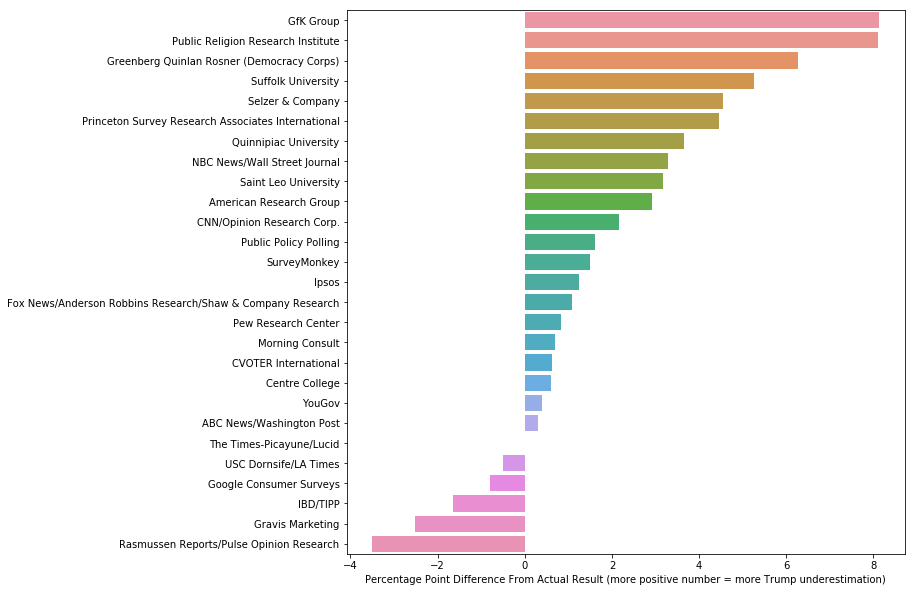

LinregressResult(slope=-0.06573106522415247, intercept=3.439767617022699, rvalue=-0.4427447646920583, pvalue=0.020738758210948508, stderr=0.026623740019566387)


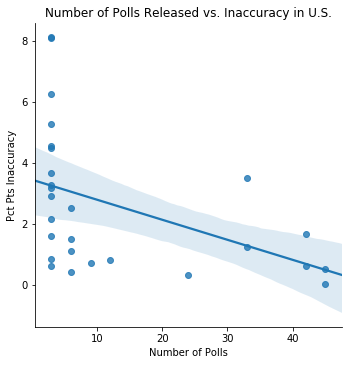

In [52]:
get_best_pollsters(trump_clinton, "U.S.", results_2016)

The Times-Picayune/Lucid, which was tied for releasing the most polls in the final two weeks leading up to the election, got an average that predicted the exact popular vote.  

There existed a moderate correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.44).  The probability that this occurred by chance is 2.07% (p = 0.0207).

### Florida

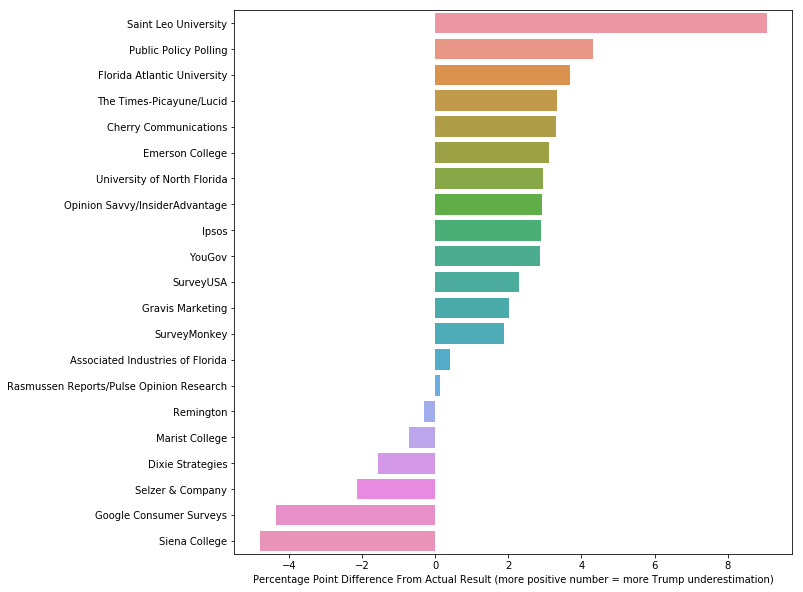

LinregressResult(slope=-0.13147978698989995, intercept=3.469762870475614, rvalue=-0.3146283867304236, pvalue=0.16480262845076044, stderr=0.09100156207579228)


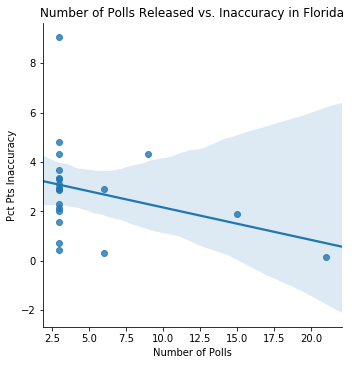

In [53]:
get_best_pollsters(trump_clinton, "Florida", results_2016)

Rasumussen predicted the Florida results very precisely, and released more polls than any other pollster.  We can also see a balance of Trump underestimation and overestimation, which makes sense due to our findings in Florida from before.  Also, it would be best to never listen to Saint Leo's polling!

There existed a moderate correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.31).  The probability that this occurred by chance is 16.5%.

### Pennsylvania

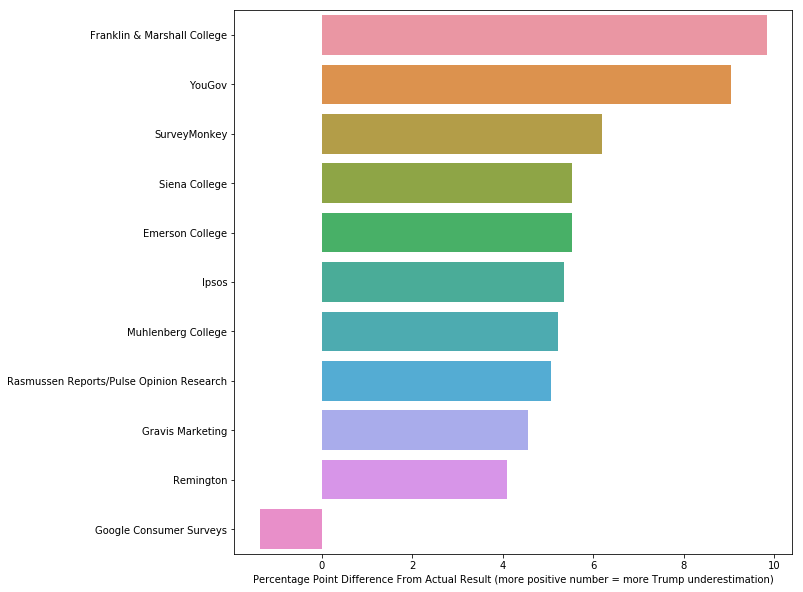

LinregressResult(slope=-0.099129985051439, intercept=6.32755812516366, rvalue=-0.2561272889451045, pvalue=0.4471278447280237, stderr=0.12470793046078664)


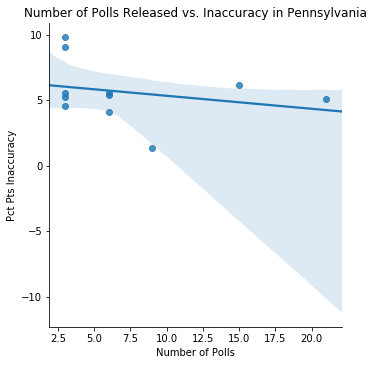

In [54]:
get_best_pollsters(trump_clinton, "Pennsylvania", results_2016)

Google Consumer Surveys was the only pollster that overestimated Trump's chances in this state, and only did so by a very small margin.

There existed a small correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.26).  The probability that this occurred by chance is 44.7%.

### Ohio

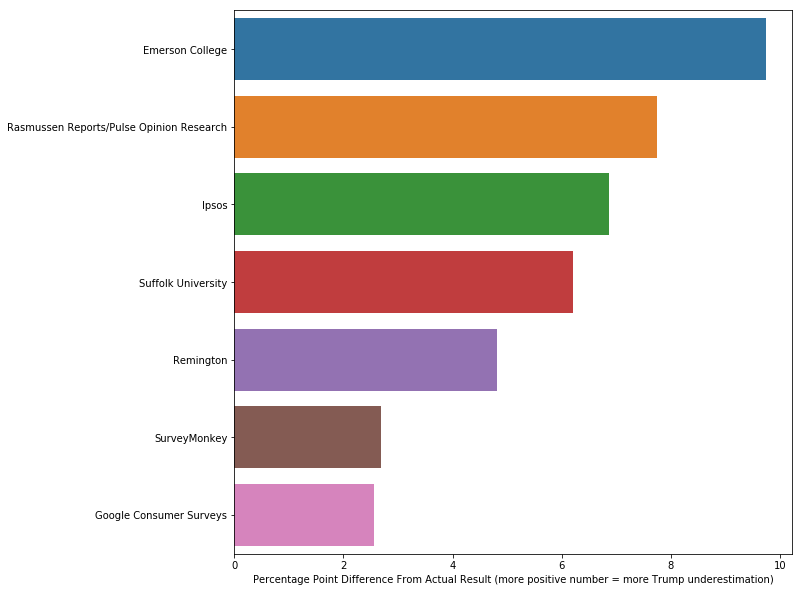

LinregressResult(slope=-0.08017725291005297, intercept=6.523640526235356, rvalue=-0.20400494703097885, pvalue=0.6608320049705139, stderr=0.17206589226208563)


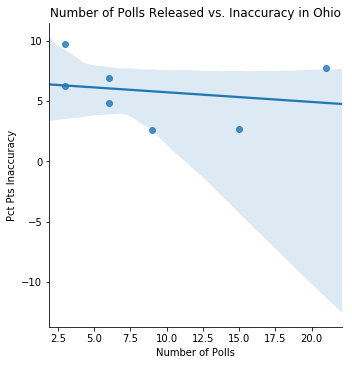

In [55]:
get_best_pollsters(trump_clinton, "Ohio", results_2016)

Again, Google Consumer Surveys gave the best prediction for Ohio, though SurveyMonkey was a very close second.

There existed a small correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.20).  The probability that this occurred by chance is 66.1%.

### Michigan

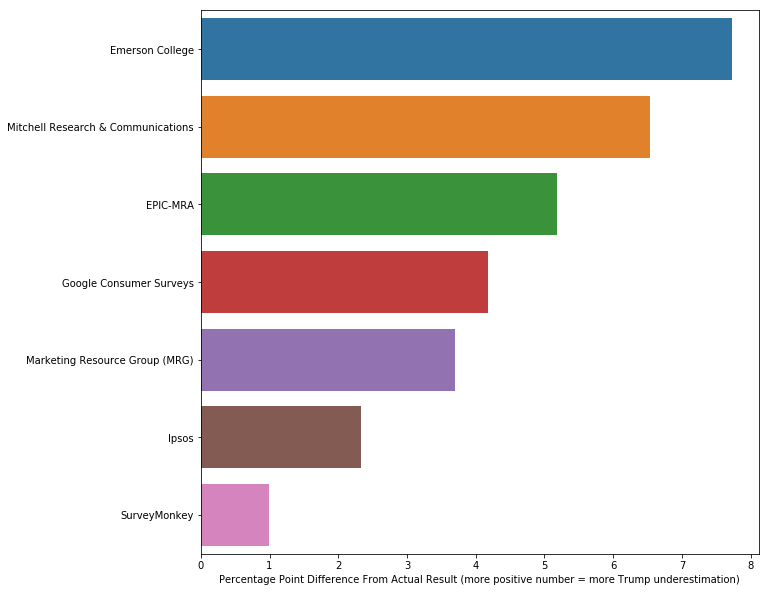

LinregressResult(slope=-0.20194192626262614, intercept=5.849446780818, rvalue=-0.4194809137866781, pvalue=0.34883172949273195, stderr=0.19543498832070583)


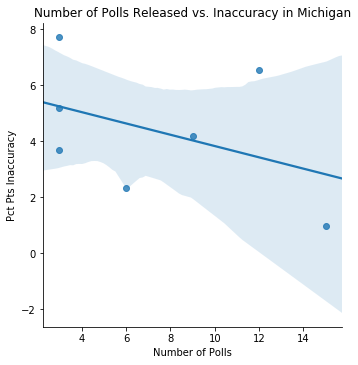

In [56]:
get_best_pollsters(trump_clinton, "Michigan", results_2016)

Another state where every pollster underestimated Trump's chances, though SurveyMonkey was very close.

There existed a moderate correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.42).  The probability that this occurred by chance is 34.5%.

### Wisconsin

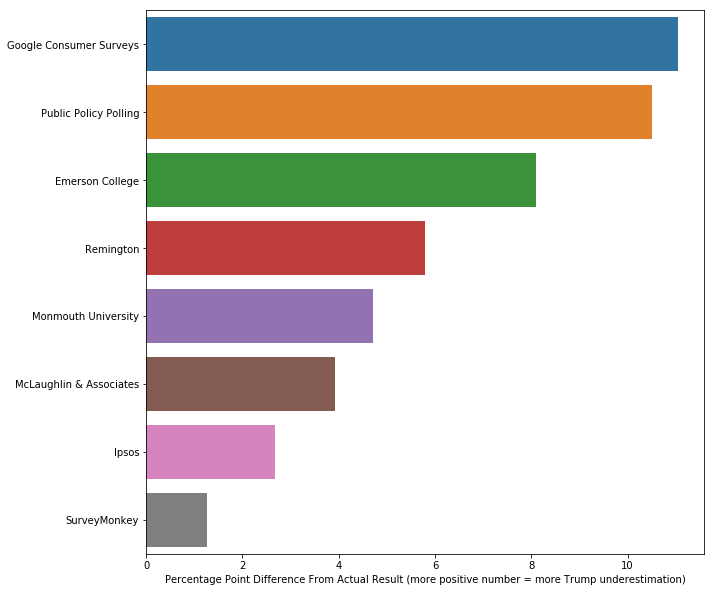

LinregressResult(slope=-0.2955132222222221, intercept=7.773837035240288, rvalue=-0.35037889678811374, pvalue=0.39482730839639807, stderr=0.3224936999037691)


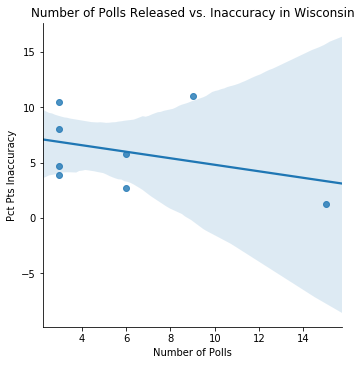

In [57]:
get_best_pollsters(trump_clinton, "Wisconsin", results_2016)

This time, Google Consumer Surveys was way off and SurveyMonkey was right on the money as they also performed the most polls.

There existed a moderate correlation between number of polls released the final two weeks before the election and inaccuracy (r = -0.35).  The probability that this occurred by chance is 39.4%.

### Minnesota

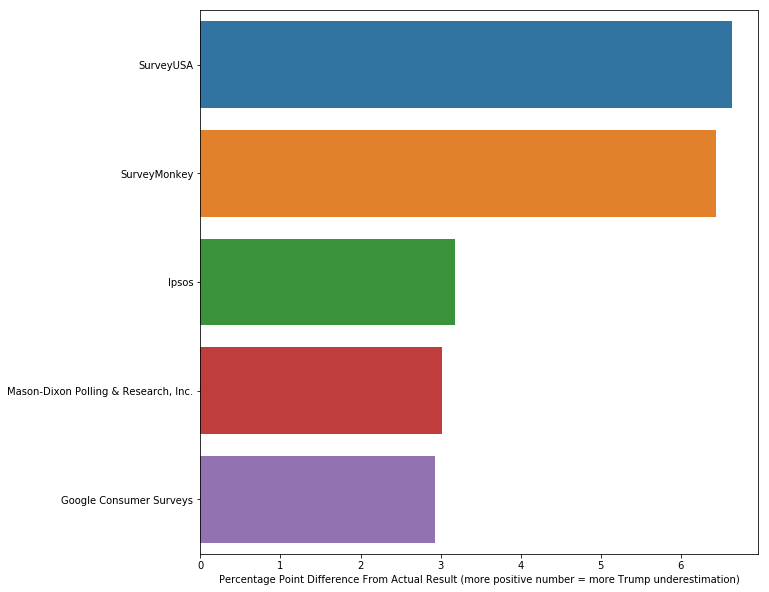

LinregressResult(slope=0.11080276587301588, intercept=3.6443364768603694, rvalue=0.28955936462226245, pvalue=0.6365403351291186, stderr=0.2114642351523154)


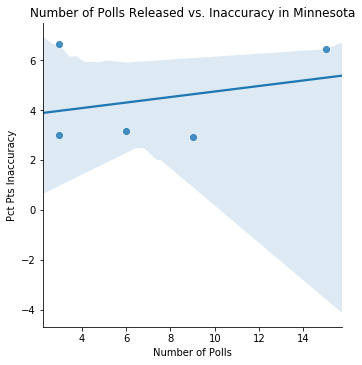

In [58]:
get_best_pollsters(trump_clinton, "Minnesota", results_2016)

Another good prediction by Google Consumer Surveys.

There existed a small positive correlation between number of polls released the final two weeks before the election and inaccuracy (r = 0.29).  The probability that this occurred by chance is 63.6%.

## Conclusions

Now, from the polling information above, what did we learn? How might we use this to interpret the 2020 polls if we assume voter and polling behavior follows similar patterns?